In [1]:
from skimage.transform import resize
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
import cv2
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imantics
from tqdm import tqdm
import ast

import warnings
warnings.filterwarnings("ignore")

image_size = 572
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


base_dir = '/home/timmy/homework_it_academy/Домашнее задание 7 модуль/data'
masks_dir = f'{base_dir}/masks'
images_dir = f'{base_dir}/images'
list_dir = os.listdir(images_dir)


cpu


In [2]:
class PreperingData():
    def __init__(self, images_dir, masks_dir, list_dir):
        self.list_dir = list_dir
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = np.zeros((len(self.list_dir), image_size, image_size, 3), dtype=np.uint8)
        self.masks = np.zeros((len(self.list_dir), image_size, image_size), dtype=np.uint8)


    def prepering_data(self, zero_array, list_dir, direct, convert):
        for ind, pic in tqdm(enumerate(list_dir)):
            if convert == 'RGB':
                cur_image = Image.open(f"{direct}/{pic}").convert("RGB")
            else:
                # cur_image = Image.open(f"{direct}/{pic}").convert("L")
                with open(f'{direct}/{pic[:-3]}json', mode='r') as f:
                    cur_image = f.read()
                    cur_image = ast.literal_eval(cur_image)
                    cur_image = np.array(cur_image)
            zero_array[ind - 1] = cur_image
        return zero_array


    def return_data(self):
        img_list = self.prepering_data(self.images, self.list_dir, self.images_dir, convert='RGB')
        masks_list = self.prepering_data(self.masks, self.list_dir, self.masks_dir, convert=None)
        return img_list, masks_list

data = PreperingData(images_dir, masks_dir, list_dir)
images, masks = data.return_data()

200it [00:01, 163.55it/s]
200it [01:39,  2.01it/s]


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, list_dir, image_size=256):
        self.images = images
        self.masks = masks
        self.transforms_imgs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.transforms_masks = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size)),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image_tensor = self.transforms_imgs(image)
        mask_tensor = self.transforms_masks(mask)
        mask_tensor = torch.Tensor(mask_tensor).long()


        return image_tensor, mask_tensor


def collate_fn(batch):
    ims, masks = list(zip(*batch))

    # Уже преобразовано в тензоры в SegmentationDataset, так что пропускаем ToTensor
    ims = torch.stack(ims).float().to(device)

    # Преобразуем маски в тензоры и убираем лишнюю размерность
    ce_masks = torch.stack([mask.squeeze() for mask in masks]).long().to(device)

    return ims, ce_masks

In [4]:
images_train, images_test_intermediate, masks_train, masks_test_intermediate = train_test_split(images, masks, test_size=0.3, random_state=42)
images_test, images_val, masks_test, masks_val = train_test_split(images_test_intermediate, masks_test_intermediate, test_size=0.3, random_state=42)

print(f"Training set shapes\nImages : {images_train.shape}\nMasks : {masks_train.shape}")
print(f"Test set shapes \nImages : {images_test.shape}\nMasks : {masks_test.shape}")
print(f"Validation set shapes \nImages : {images_val.shape}\nMasks : {masks_val.shape}")

Training set shapes
Images : (140, 572, 572, 3)
Masks : (140, 572, 572)
Test set shapes 
Images : (42, 572, 572, 3)
Masks : (42, 572, 572)
Validation set shapes 
Images : (18, 572, 572, 3)
Masks : (18, 572, 572)


In [5]:
from torch.utils.data import DataLoader

# Создаем датасеты
train_ds = SegmentationDataset(images_train, masks_train, list_dir)
test_ds = SegmentationDataset(images_test, masks_test, list_dir)
val_ds = SegmentationDataset(images_val, masks_val, list_dir)

# Создаем DataLoader для обучающей и тестовой выборки
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

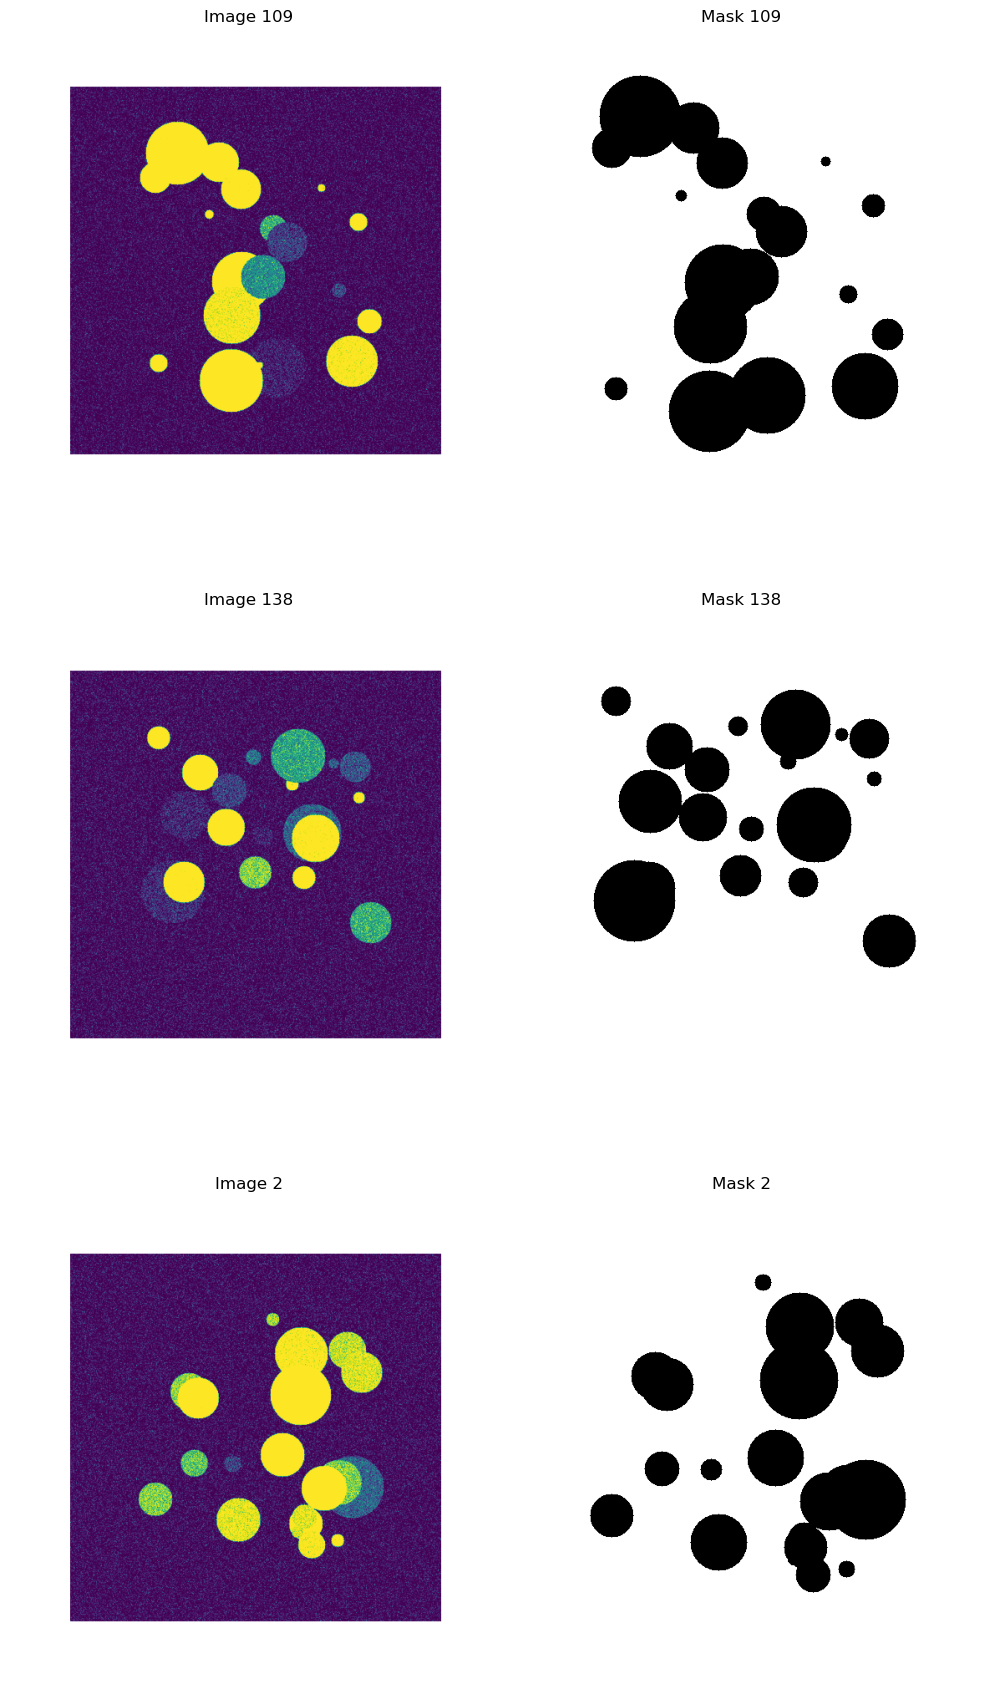

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Функция для визуализации случайных изображений с масками
def visualize_random_images_with_masks(images, masks, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 6 * num_samples))

    # Выбираем случайные индексы для визуализации
    random_indices = random.sample(range(len(images)), num_samples)

    for i, idx in enumerate(random_indices):
        image = images[idx]
        mask = masks[idx]

        # Ожидаем, что изображения имеют 3 канала
        ax_image = axes[i, 0]
        ax_mask = axes[i, 1]

        # Отображаем изображение
        ax_image.imshow(image)
        ax_image.set_title(f"Image {idx}")
        ax_image.axis('off')

        # Отображаем маску
        ax_mask.imshow(mask.squeeze(), cmap='Greys')
        ax_mask.set_title(f"Mask {idx}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_images_with_masks(images_train, masks_train)

In [7]:
# сверточный блок для левой части архитектуры

def convolve(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )


# апсемплинг блок для правой части архитектуры

def up_convolve(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
        nn.ReLU(inplace = True)
    )


# Функция двойной свёртки
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
        )

# Теперь определим всю архитектуру для U-Net:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=2):
        super().__init__()
        # Будем использовать модель VGG-16 в качестве энкодера
        self.encoder = vgg16_bn(pretrained=pretrained).features
        # Разделим VGG поблочно на отдельные блоки чтобы было удобно их модифицировать и обращаться к ним
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        # Боттлнек нашей архитектуры (самый глубокий уровень сети -> смотри архитектуру U-Net на картинке выше)
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = convolve(512, 1024)

        # Блоки декодера с "транспонированными свертками" и сверточными блоками
        self.up_conv6 = up_convolve(1024, 512)
        self.conv6 = convolve(512 + 512, 512)
        self.up_conv7 = up_convolve(512, 256)
        self.conv7 = convolve(256 + 512, 256)
        self.up_conv8 = up_convolve(256, 128)
        self.conv8 = convolve(128 + 256, 128)
        self.up_conv9 = up_convolve(128, 64)
        self.conv9 = convolve(64 + 128, 64)
        self.up_conv10 = up_convolve(64, 32)
        self.conv10 = convolve(32 + 64, 32)
        # Финальный сверточный слой для приведения к нужному числу каналов
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    
    def forward(self, x):
        # Проход через блоки энкодера
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        # Проход через блок боттлнека
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        # Проход через блоки декодера с использованием "skip connections"
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        # Проход через финальный свёрточный слой
        x = self.conv11(x)

        return x




ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc


def train_batch(model, data, optimizer, criterion):
    model.train()  # Убедитесь, что модель в обучающем режиме
    ims, ce_masks = data  # Загружаем изображения и маски
    _masks = model(ims)  # Прогоняем изображения через модель
    optimizer.zero_grad()  # Обнуляем градиенты
    loss, acc = criterion(_masks, ce_masks)  # Рассчитываем лосс и точность
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    return loss.item(), acc.item()  # Возвращаем значения лосса и точности


@torch.no_grad()  # Отключаем градиенты для валидации
def validate_batch(model, data, criterion):
    model.eval()  # Устанавливаем модель в режим инференса
    ims, masks = data  # Загружаем изображения и маски
    _masks = model(ims)  # Прогоняем изображения через модель
    loss, acc = criterion(_masks, masks)  # Рассчитываем лосс и точность
    return loss.item(), acc.item()  # Возвращаем значения лосса и точности

Train Epoch [1/5] Batch [1/35] train_loss: 0.6114, train_acc: 0.7719
Train Epoch [1/5] Batch [2/35] train_loss: 0.5446, train_acc: 0.8915
Train Epoch [1/5] Batch [3/35] train_loss: 0.4956, train_acc: 0.9602
Train Epoch [1/5] Batch [4/35] train_loss: 0.4621, train_acc: 0.9858
Train Epoch [1/5] Batch [5/35] train_loss: 0.4337, train_acc: 0.9926
Train Epoch [1/5] Batch [6/35] train_loss: 0.4121, train_acc: 0.9954
Train Epoch [1/5] Batch [7/35] train_loss: 0.3909, train_acc: 0.9976
Train Epoch [1/5] Batch [8/35] train_loss: 0.3748, train_acc: 0.9983
Train Epoch [1/5] Batch [9/35] train_loss: 0.3599, train_acc: 0.9986
Train Epoch [1/5] Batch [10/35] train_loss: 0.3501, train_acc: 0.9985
Train Epoch [1/5] Batch [11/35] train_loss: 0.3371, train_acc: 0.9997
Train Epoch [1/5] Batch [12/35] train_loss: 0.3262, train_acc: 0.9997
Train Epoch [1/5] Batch [13/35] train_loss: 0.3159, train_acc: 1.0000
Train Epoch [1/5] Batch [14/35] train_loss: 0.3054, train_acc: 1.0000
Train Epoch [1/5] Batch [15/3

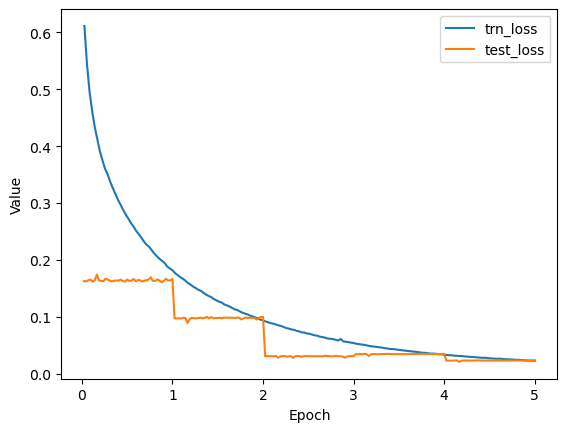

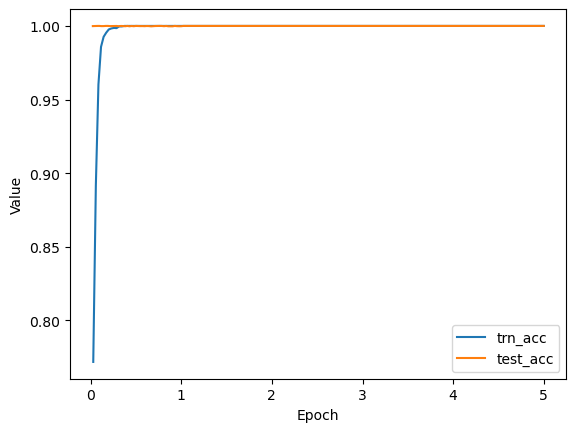

In [8]:
from torch import optim

model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5


import matplotlib.pyplot as plt

class Report:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.metrics = {'trn_loss': [], 'test_loss': [],
                        'trn_acc': [], 'test_acc': []}
        self.steps = {key: [] for key in self.metrics}

    def record(self, pos, **kwargs):
        for key, value in kwargs.items():
            if key in self.metrics:
                self.metrics[key].append(value)
                self.steps[key].append(pos)

    def plot_epochs(self, metrics):
        for metric in metrics:
            plt.plot(self.steps[metric], self.metrics[metric], label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.show()


log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, trn_loss=loss, trn_acc=acc)
        print(f'Train Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'train_loss: {loss:.4f}, train_acc: {acc:.4f}')

    N = len(test_dl)
    for bx, data in enumerate(test_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex + (bx + 1) / N, test_loss=loss, test_acc=acc)
        print(f'Test Epoch [{ex+1}/{n_epochs}] '
              f'Batch [{bx+1}/{N}] '
              f'test_loss: {loss:.4f}, test_acc: {acc:.4f}')

    print()


log.plot_epochs(['trn_loss','test_loss'])
log.plot_epochs(['trn_acc','test_acc'])

In [9]:
val_log = Report(1)
for ex in range(1):
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        val_log.record(ex + (bx + 1) / N, val_loss=loss, val_acc=acc)
        print(f'Validation Epoch [{ex+1}/1] '
              f'Batch [{bx+1}/{N}] '
              f'Validation_loss: {loss:.4f}, validation_acc: {acc:.4f}')

Validation Epoch [1/1] Batch [1/18] Validation_loss: 0.0233, validation_acc: 1.0000
Validation Epoch [1/1] Batch [2/18] Validation_loss: 0.0233, validation_acc: 1.0000
Validation Epoch [1/1] Batch [3/18] Validation_loss: 0.0231, validation_acc: 1.0000
Validation Epoch [1/1] Batch [4/18] Validation_loss: 0.0232, validation_acc: 1.0000
Validation Epoch [1/1] Batch [5/18] Validation_loss: 0.0234, validation_acc: 1.0000
Validation Epoch [1/1] Batch [6/18] Validation_loss: 0.0206, validation_acc: 1.0000
Validation Epoch [1/1] Batch [7/18] Validation_loss: 0.0232, validation_acc: 1.0000
Validation Epoch [1/1] Batch [8/18] Validation_loss: 0.0231, validation_acc: 1.0000
Validation Epoch [1/1] Batch [9/18] Validation_loss: 0.0233, validation_acc: 1.0000
Validation Epoch [1/1] Batch [10/18] Validation_loss: 0.0231, validation_acc: 1.0000
Validation Epoch [1/1] Batch [11/18] Validation_loss: 0.0231, validation_acc: 1.0000
Validation Epoch [1/1] Batch [12/18] Validation_loss: 0.0231, validation_a

In [10]:
torch.save(model, "unet_blobs_detector.pth")

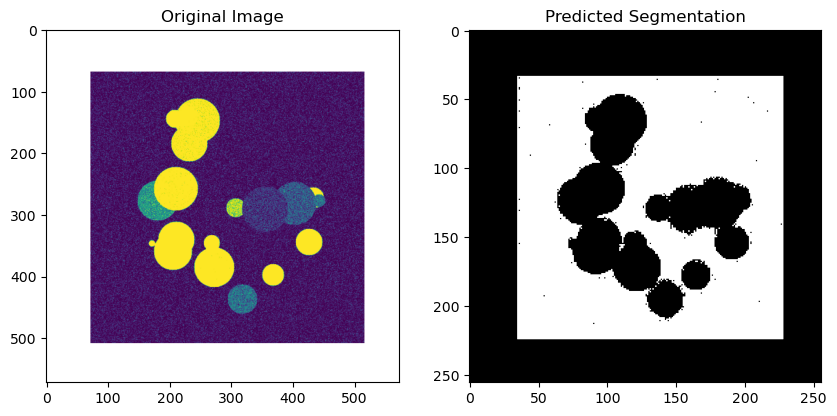

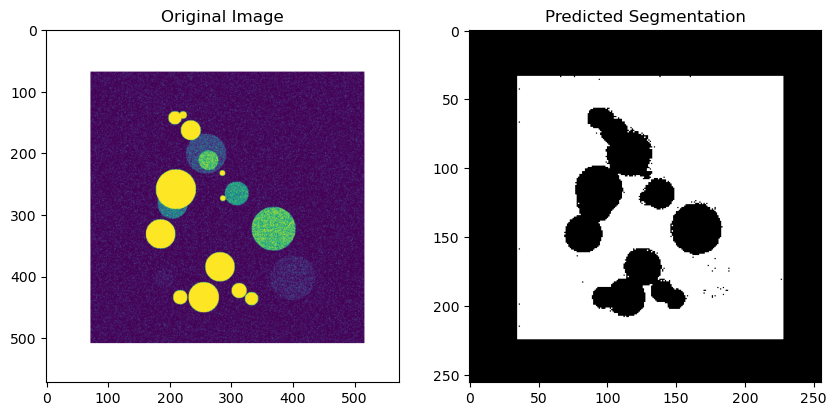

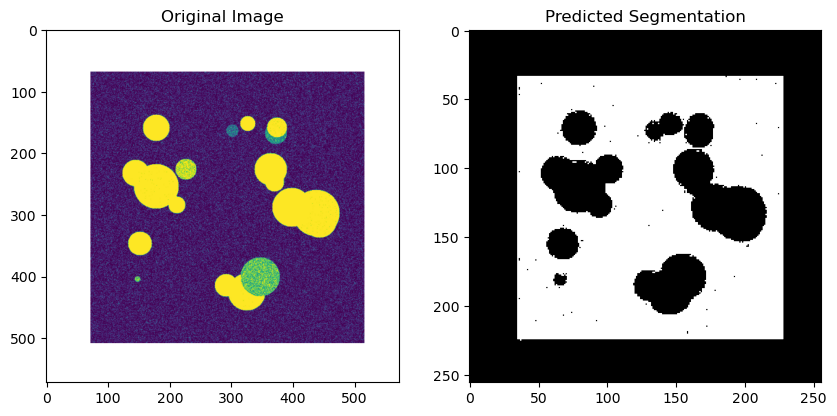

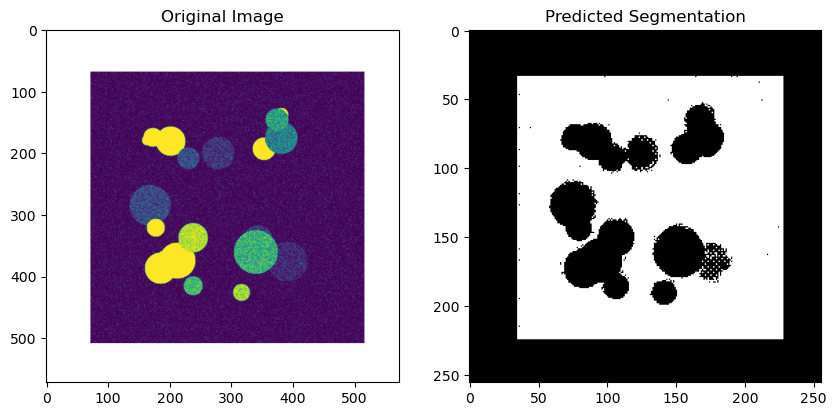

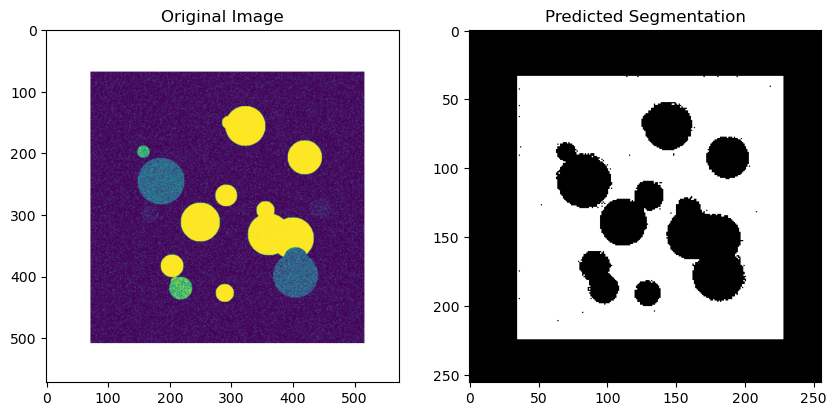

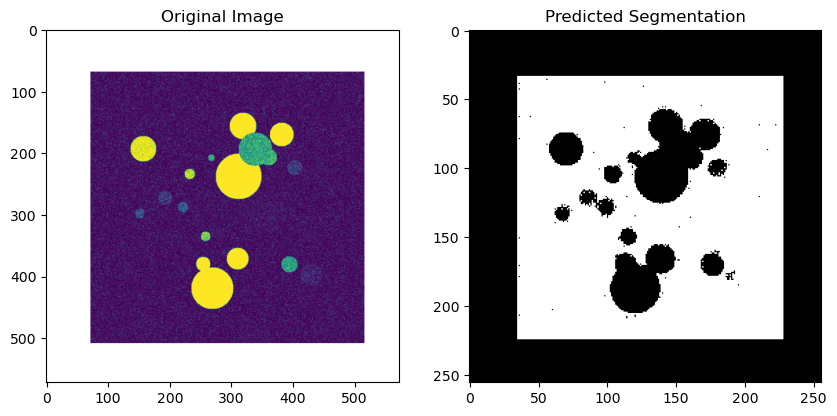

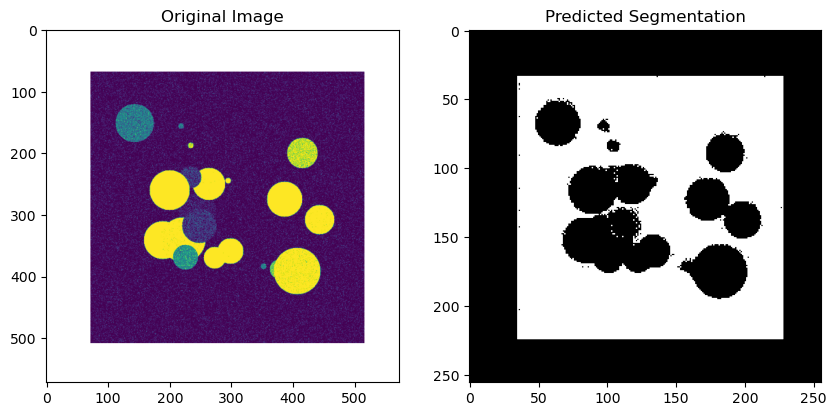

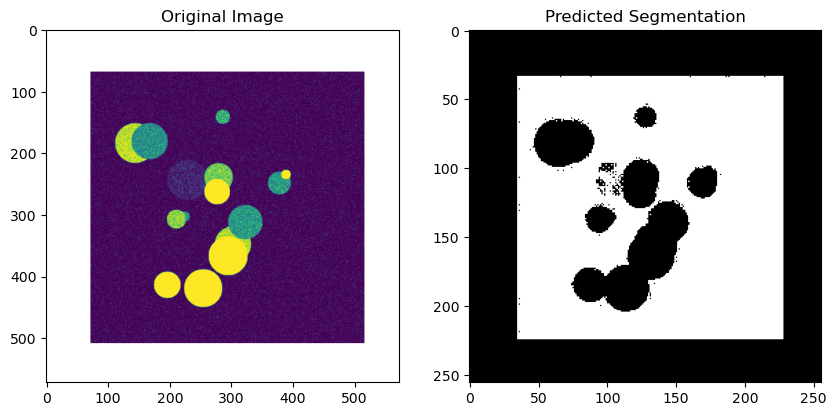

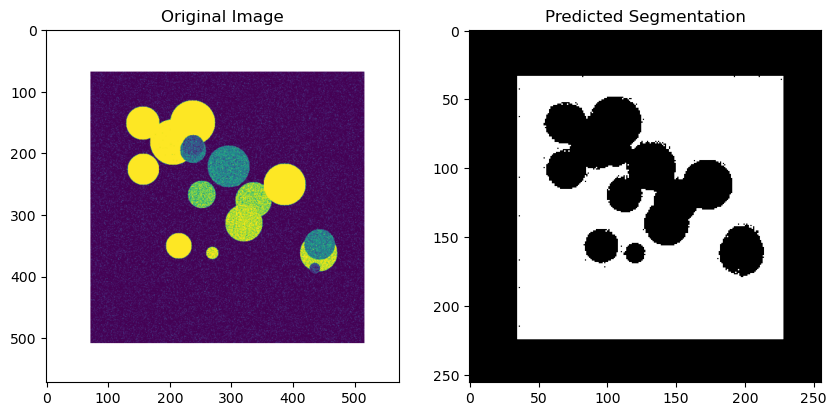

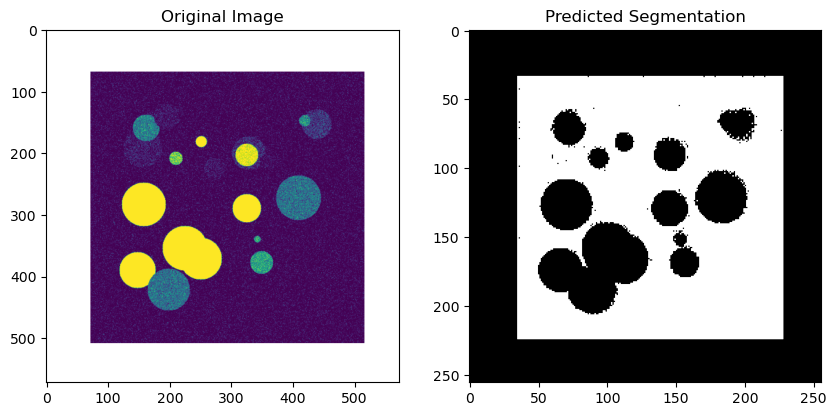

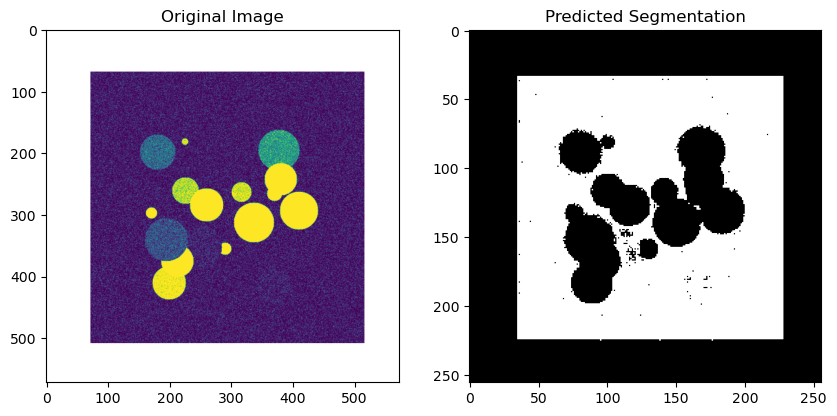

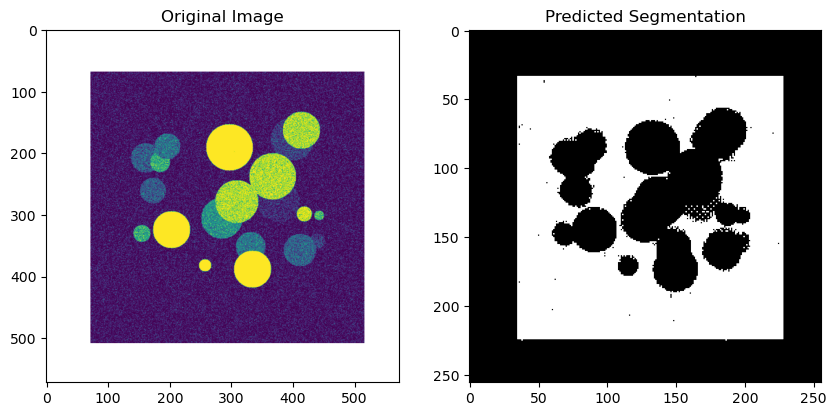

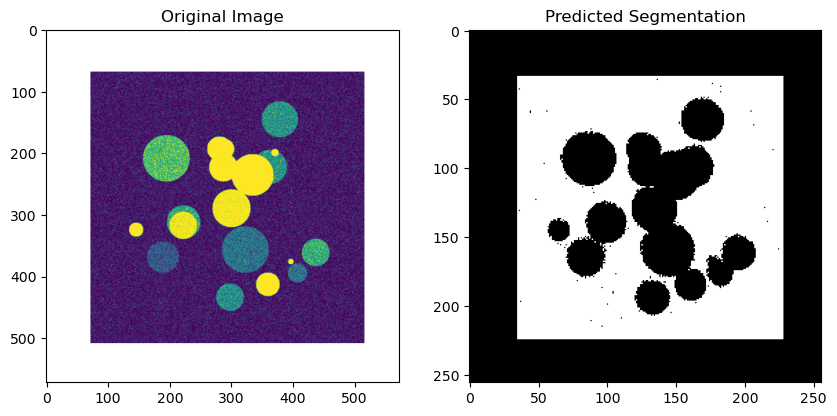

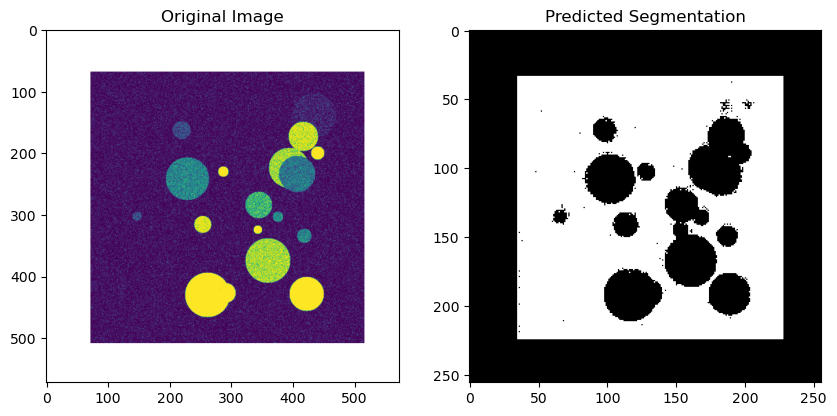

In [127]:
# Функция для выполнения инференса на изображении
import json
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Путь к директории с изображениями
base_dir = '/home/timmy/homework_it_academy/Домашнее задание 7 модуль/validation/images/'

# Преобразования для изображений
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем в тензор
    transforms.Resize((256, 256)),  # Приводим все изображения к нужному размеру
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Функция для выполнения инференса на изображении
def infer_image(model, image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).cpu()  # Добавляем batch-измерение и перемещаем на GPU
    model.eval()  # Устанавливаем модель в режим инференса
    with torch.no_grad():  # Отключаем вычисление градиентов
        output = model(image)  # Получаем предсказания
    return output

# Получаем все изображения из директории
image_paths = [os.path.join(base_dir, fname) for fname in os.listdir(base_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Проходим по всем изображениям и рисуем результат
for image_path in image_paths:
    # Выполняем инференс
    
    output = infer_image(model, image_path)
    
    # Преобразуем вывод в формат изображения (для одного изображения)
    output = output.squeeze(0)
    output = output.max(dim=0)[0]
    output[output <= 1.45] = 0
    output[output > 1.45] = 1

    original_image = Image.open(image_path)

    # Отображаем исходное изображение и предсказание
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output, cmap='Grays')  # Отображаем сегментацию в оттенках серого
    plt.title('Predicted Segmentation')

    plt.show()